In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
==> Preparing data..


100%|██████████| 170M/170M [00:01<00:00, 87.5MB/s] 


==> Building model..

Epoch: 1/40 -- LR: 0.10000
  Batch 1/391 | Loss: 2.687 | Acc: 10.938% (14/128) | BatchTime: 1.330s | DataTime: 0.121s
  Batch 101/391 | Loss: 2.146 | Acc: 20.320% (2627/12928) | BatchTime: 0.062s | DataTime: 0.003s
  Batch 201/391 | Loss: 2.003 | Acc: 25.074% (6451/25728) | BatchTime: 0.055s | DataTime: 0.003s
  Batch 301/391 | Loss: 1.911 | Acc: 28.501% (10981/38528) | BatchTime: 0.053s | DataTime: 0.002s
  Batch 391/391 | Loss: 1.838 | Acc: 31.294% (15647/50000) | BatchTime: 0.052s | DataTime: 0.002s
Test Results: Loss: 1.646 | Acc: 41.090% (4109/10000)
Epoch 1 duration: 21.92 seconds

Epoch: 2/40 -- LR: 0.10000
  Batch 1/391 | Loss: 1.488 | Acc: 46.094% (59/128) | BatchTime: 0.167s | DataTime: 0.107s
  Batch 101/391 | Loss: 1.497 | Acc: 45.096% (5830/12928) | BatchTime: 0.050s | DataTime: 0.003s
  Batch 201/391 | Loss: 1.438 | Acc: 47.427% (12202/25728) | BatchTime: 0.050s | DataTime: 0.002s
  Batch 301/391 | Loss: 1.385 | Acc: 49.323% (19003/38528) | BatchTime

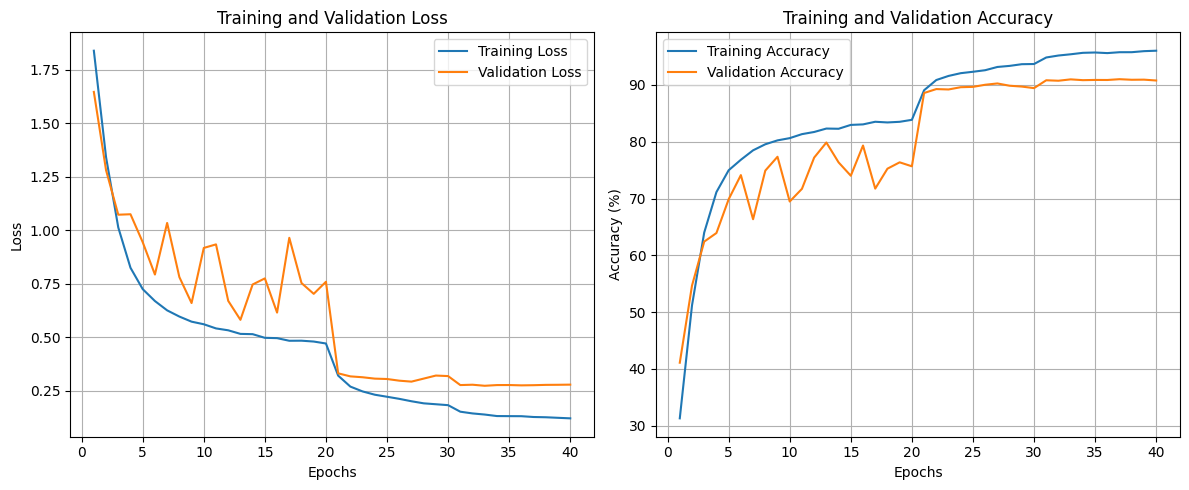

==> Training finished. Plots saved to resnet32_cifar10_training_plots.png


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_EPOCHS = 40 # The paper trains for 64k iterations, which is more epochs on CIFAR10
BATCH_SIZE = 128
LEARNING_RATE = 0.1 # Initial LR, will be decayed
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4 # Or 1e-4 as in paper

# --- Data Preparation ---
print("==> Preparing data..")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# --- ResNet Model Definition ---

# BasicBlock: The standard residual block for ResNets like ResNet-18/34
class BasicBlock(nn.Module):
    expansion = 1 # For BasicBlock, input channels == output channels

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        # If stride is not 1 (downsampling) or in_planes is different from planes * expansion
        # then we need a projection shortcut to match dimensions.
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # Add the shortcut
        out = F.relu(out)      # Apply ReLU after addition
        return out

# Bottleneck Block: Used in deeper ResNets like ResNet-50/101/152
# Not strictly needed for CIFAR-10 ResNet-32, but good to have for completeness
class Bottleneck(nn.Module):
    expansion = 4 # Output channels are 4x input channels to the first 1x1 conv

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, # planes * 4
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16 # Initial number of planes for CIFAR-10 specific ResNet

        # Initial convolution (as per CIFAR-10 section in ResNet paper)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Residual blocks
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2) # Downsample
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2) # Downsample
        
        # CIFAR-10 variant doesn't typically use a 4th layer of blocks before pooling
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2) 
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling
        self.linear = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # First block might have a stride, others stride 1
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion # Update in_planes for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out) # if using layer4
        out = self.avgpool(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.linear(out)
        return out

# Specific ResNet architectures for CIFAR-10
# The paper uses 6n+2 layers, where n is the number of blocks in each stage
# e.g., ResNet-20 (n=3) -> [3,3,3] blocks
# e.g., ResNet-32 (n=5) -> [5,5,5] blocks
# e.g., ResNet-56 (n=9) -> [9,9,9] blocks

def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])

def ResNet32():
    return ResNet(BasicBlock, [5, 5, 5]) # This is our target

def ResNet56():
    return ResNet(BasicBlock, [9, 9, 9])

# --- Model Initialization, Loss, Optimizer ---
print('==> Building model..')
net = ResNet32() # Using ResNet-32 for CIFAR-10
net = net.to(DEVICE)

# Optional: For multi-GPU
# if DEVICE == 'cuda':
#     net = torch.nn.DataParallel(net)
#     torch.backends.cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler: decay LR at specific epochs
# The paper uses 32k and 48k iterations. For CIFAR-10 with batch_size 128:
# 50000 images / 128 batch_size = ~390 iterations per epoch
# 32000 iterations / 390 iter/epoch = ~82 epochs
# 48000 iterations / 390 iter/epoch = ~123 epochs
# For fewer epochs, we adjust:
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80, 120], gamma=0.1)
# For NUM_EPOCHS = 40, let's try decaying at epoch 20 and 30
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[round(NUM_EPOCHS*0.5), round(NUM_EPOCHS*0.75)], gamma=0.1)


# --- Training Function ---
def train(epoch):
    print(f'\nEpoch: {epoch+1}/{NUM_EPOCHS} -- LR: {scheduler.get_last_lr()[0]:.5f}')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    batch_time_sum = 0
    data_time_sum = 0
    
    end_time = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        data_time = time.time() - end_time # Measure data loading time
        
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        batch_time = time.time() - end_time # Measure batch processing time
        end_time = time.time() # Reset for next iteration
        
        batch_time_sum += batch_time
        data_time_sum += data_time

        if batch_idx % 100 == 0 or batch_idx == len(trainloader)-1:
            print(f'  Batch {batch_idx+1}/{len(trainloader)} | Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total}) '
                  f'| BatchTime: {batch_time_sum/(batch_idx+1):.3f}s | DataTime: {data_time_sum/(batch_idx+1):.3f}s')
    
    avg_loss = train_loss / len(trainloader)
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc

# --- Testing Function ---
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = test_loss / len(testloader)
    avg_acc = 100. * correct / total
    print(f'Test Results: Loss: {avg_loss:.3f} | Acc: {avg_acc:.3f}% ({correct}/{total})')
    return avg_loss, avg_acc

# --- Main Training Loop & Plotting ---
train_losses, test_losses = [], []
train_accs, test_accs = [], []

start_total_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    
    tr_loss, tr_acc = train(epoch)
    te_loss, te_acc = test(epoch)
    scheduler.step() # Update learning rate

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    test_losses.append(te_loss)
    test_accs.append(te_acc)
    
    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} duration: {epoch_duration:.2f} seconds")

total_training_time = time.time() - start_total_time
print(f"\nTotal training time: {total_training_time/60:.2f} minutes")

# --- Plotting Results ---
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Training Accuracy')
plt.plot(epochs_range, test_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('resnet32_cifar10_training_plots.png')
plt.show()

print("==> Training finished. Plots saved to resnet32_cifar10_training_plots.png")

# Optional: Save the model
# torch.save(net.state_dict(), 'resnet32_cifar10.pth')
# print("Model saved to resnet32_cifar10.pth")